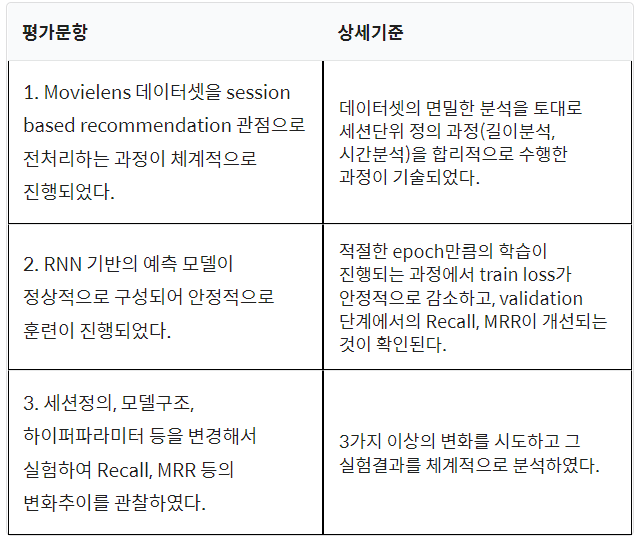

# 0. 라이브러이 준비준비

In [2]:
import pandas as pd
import tensorflow as tf

print(tf.__version__)
print(pd.__version__)

2.6.0
1.3.3


In [1]:
import datetime as dt
from pathlib import Path
import os

import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# 1. 데이터 준비

In [3]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


**UserID: 이용자 ID**   
**Rating: 이용자 평가**    
**Time : UTC time. 1970년 1월 1일부터 경과된 초 단위 시간이 기재되어 있음**

In [4]:
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

## 1-1. User Length

In [5]:
user_length = data.groupby('UserId').size()
user_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [6]:
user_length.median()
user_length.mean()
print("User가 평균적으로 시청한 작품 = ",user_length.mean())

User가 평균적으로 시청한 작품 =  165.5975165562914


In [7]:
user_length.min(), user_length.max()
print("User가 최소 시청한 작품수 = ", user_length.min())
print("User가 최대 시청한 작품수 = ", user_length.max())

User가 최소 시청한 작품수 =  20
User가 최대 시청한 작품수 =  2314


In [8]:
long_user = user_length[user_length==2314].index[0]
data[data['UserId']==long_user]

,UserId,ItemId,Rating,Time
696969,4169,1268,5,965333392
697168,4169,2617,4,965333392
697185,4169,2628,4,965333392
697219,4169,2653,4,965333392
697275,4169,423,3,965333392
...,...,...,...,...
697882,4169,3754,2,1024174347
695702,4169,1413,3,1024175031
697358,4169,494,4,1024175760
695945,4169,1804,2,1024175783


In [9]:
print("UserID_4169가 최대작품수를 시청한 고객이다.")

UserID_4169가 최대작품수를 시청한 고객이다.


In [10]:
user_length.quantile(0.999)
print("User중 99.9%가 시청한 작품수 = ",user_length.quantile(0.999))

User중 99.9%가 시청한 작품수 =  1343.181000000005


In [11]:
length_count = user_length.groupby(user_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

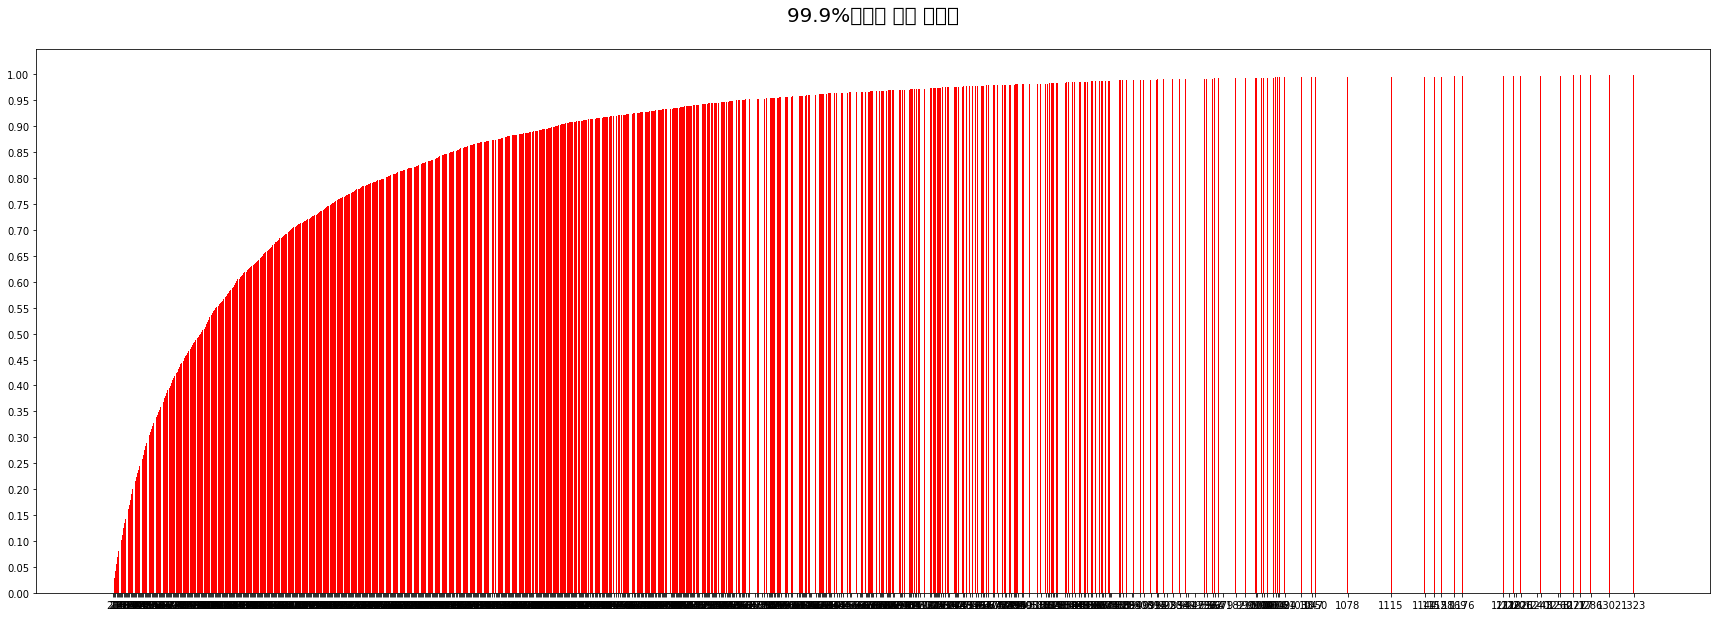

In [12]:
plt.figure(figsize=(30, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('99.9%까지의 분포 누적합\n', size=20)
plt.show()

In [13]:
users = user_length[user_length > 900].index
users

Int64Index([ 424,  524,  549,  550,  678,  752,  881,  889, 1010, 1015, 1019,
            1088, 1150, 1181, 1285, 1447, 1448, 1449, 1605, 1680, 1698, 1880,
            1912, 1941, 1980, 2015, 2063, 2116, 2181, 2909, 3032, 3224, 3292,
            3311, 3391, 3507, 3526, 3539, 3618, 3778, 3808, 3824, 3841, 4064,
            4169, 4227, 4277, 4344, 4425, 4447, 4448, 4508, 4510, 4543, 4725,
            4808, 5367, 5643, 5795, 5831, 5954, 6016],
           dtype='int64', name='UserId')

##### users를 하위 99%만 남기고 1%의 OUTLIERS를 제거하자!!

In [14]:
data = data[~data['UserId'].isin(users)]
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


In [15]:
user_length = data.groupby('UserId').size()
user_length.min(), user_length.max()

(20, 900)

##### USER는 20명이고 최대 900개의 작품을 감사하였다.

## 1-2. Session Time

In [16]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

956703932
1046454590


In [17]:
type(latest)

numpy.int64

In [18]:
dt.timedelta(30)

datetime.timedelta(days=30)

In [19]:
data['Time'] = pd.to_datetime(data['Time'], unit='s')
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


In [20]:
oldest, latest = data['Time'].min(), data['Time'].max()
print("가장 오래된 날짜:", oldest) 
print("가장 최근 날짜:", latest)

가장 오래된 날짜: 2000-04-25 23:05:32
가장 최근 날짜: 2003-02-28 17:49:50


In [21]:
type(latest)

pandas._libs.tslibs.timestamps.Timestamp

## 2-4. Data Cleansing

In [22]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('UserId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['UserId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [23]:
data = cleanse_recursive(data, shortest=2, least_click=5)
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


#### 2000/12/31 ~ 2021년 8/20까지의 자료 → 총 8개월 20일

## 2.5 Train / Valid / Test split

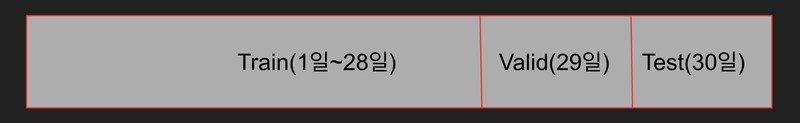

In [24]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    user_last_time = data.groupby('Time')['Time'].max()
    user_in_train = user_last_time[user_last_time < final_time - dt.timedelta(n_days)].index
    user_in_test = user_last_time[user_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['Time'].isin(user_in_train)]
    after_date = data[data['Time'].isin(user_in_test)]
    return before_date, after_date

In [25]:
tr, test = split_by_date(data, n_days=90)
tr, val = split_by_date(tr, n_days=90)

#### 위 그림에서는  dataset이 1달(30일)일 경우 이지만 이번은 약 250일 이상이었다. 본인은 여기서 50일을 해보았지만 결과가 좋지 못하여 90일로 변경하였다. 이때 채은님의 EXP 도움을 받았다.

In [26]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Userss: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [27]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 920970
	 Userss: 5977
	 Items: 3386
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2002-09-01 04:20:59

* valid Set Stats Info
	 Events: 3740
	 Userss: 216
	 Items: 1635
	 First Time : 2002-09-01 19:41:39
	 Last Time : 2002-11-30 13:47:32

* test Set Stats Info
	 Events: 4130
	 Userss: 216
	 Items: 1675
	 First Time : 2002-11-30 20:24:52
	 Last Time : 2003-02-28 17:49:50



In [28]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [29]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

# 2. 미니 배치의 구성    
실습 코드 내역을 참고하여 데이터셋과 미니 배치를 구성해 봅시다. Session-Parallel Mini-Batch의 개념에 따라, 학습 속도의 저하가 최소화될 수 있도록 구성합니다.
단, 위 Step 1에서 Session 단위를 어떻게 정의했느냐에 따라서 Session-Parallel Mini-Batch이 굳이 필요하지 않을 수도 있습니다.

## 2-1. SessionDataset

In [30]:
class UserDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.user_idx = np.arange(self.df['UserId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [31]:
tr_dataset = UserDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2000-12-31 22:00:19,0
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,2
37,1,1022,5,2000-12-31 22:00:55,3
24,1,2340,3,2000-12-31 22:01:43,4
36,1,1836,5,2000-12-31 22:02:52,5
3,1,3408,4,2000-12-31 22:04:35,6
7,1,2804,5,2000-12-31 22:11:59,7
47,1,1207,4,2000-12-31 22:11:59,8
0,1,1193,5,2000-12-31 22:12:40,9


In [32]:
tr_dataset.click_offsets

array([     0,     53,    182, ..., 920506, 920629, 920970], dtype=int32)

In [33]:
tr_dataset.user_idx

array([   0,    1,    2, ..., 5974, 5975, 5976])

## 2-2. SessionDataLoader

In [34]:
class UserDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: UserDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_user, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where User Start
        end : Index Where User End
        mask : indicator for the users to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Users
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_user, finished = self.update_status(start, end, min_len, last_user, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_user = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.user_idx[first_iters]]       # data 상에서 user이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.user_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # user의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_user, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_user: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 user이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_user = last_user + i  
            if new_user > self.dataset.user_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.user_idx[new_user]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.user_idx[new_user] + 1]

        last_user += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_user, finished

In [35]:
tr_data_loader = UserDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2000-12-31 22:00:19,0
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,2
37,1,1022,5,2000-12-31 22:00:55,3
24,1,2340,3,2000-12-31 22:01:43,4
36,1,1836,5,2000-12-31 22:02:52,5
3,1,3408,4,2000-12-31 22:04:35,6
7,1,2804,5,2000-12-31 22:11:59,7
47,1,1207,4,2000-12-31 22:11:59,8
0,1,1193,5,2000-12-31 22:12:40,9


In [36]:
iter_ex = iter(tr_data_loader)

In [37]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0 53 65 54]
Label Item Idx are :       [ 1 54 62 24]
Previous Masked Input Idx are []


# 3. 모델 구성    
이 부분도 실습 코드 내역을 참고하여 다양하게 모델 구조를 시도해 볼 수 있습니다.

## 3-1. Evaluation Metric

In [38]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

## 3-2. Model Architecture

In [39]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [40]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [41]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_users = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=2048, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)

In [42]:
model = create_model(args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(2048, 1, 3386)]         0         
_________________________________________________________________
GRU (GRU)                    [(2048, 50), (2048, 50)]  515700    
_________________________________________________________________
dropout (Dropout)            (2048, 50)                0         
_________________________________________________________________
dense (Dense)                (2048, 3386)              172686    
Total params: 688,386
Trainable params: 688,386
Non-trainable params: 0
_________________________________________________________________


## 3-3. Model Training

In [43]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = UserDataset(args.tr)
    train_loader = UserDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = UserDataset(data)
    loader = UserDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [44]:
# 학습 시간이 다소 오래 소요됩니다. 아래 주석을 풀지 마세요.
# train_model(model, args)

# 학습된 모델을 불러옵니다.
model = tf.keras.models.load_model(data_path / 'trained_model')

## 3-4. Inference

In [45]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

# 4. 모델 학습     
다양한 하이퍼파라미터를 변경해 보며 검증해 보도록 합니다. 실습 코드에 언급되었던 Recall, MRR 등의 개념들도 함께 관리될 수 있도록 합니다.

### 4-1. Hyperparameters-1   
##### batch_size=256, hsz=50, drop_rate=0.1, lr=0.001, epochs=5, k=20

In [46]:
args1 = Args(tr, val, test, batch_size=256, hsz=50, drop_rate=0.1, lr=0.001, epochs=5, k=20)

model1 = create_model(args1)

train_model(model1, args1)

test_model(model1, args1, test)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(256, 1, 3386)]          0         
_________________________________________________________________
GRU (GRU)                    [(256, 50), (256, 50)]    515700    
_________________________________________________________________
dropout_1 (Dropout)          (256, 50)                 0         
_________________________________________________________________
dense_1 (Dense)              (256, 3386)               172686    
Total params: 688,386
Trainable params: 688,386
Non-trainable params: 0
_________________________________________________________________


Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]


IndexError: index 216 is out of bounds for axis 0 with size 216

# 5. 모델 테스트    
미리 구성한 테스트셋을 바탕으로 Recall, MRR 을 확인해 봅니다.

### 5-1. Hyperparameters-2   
##### batch_size=256, hsz=50, drop_rate=0.1, lr=0.001, epochs=5, k=20

In [47]:
args2 = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=5, k=20)

model2 = create_model(args2)

train_model(model2, args2)

test_model(model2, args2, test)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(128, 1, 3386)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    515700    
_________________________________________________________________
dropout_2 (Dropout)          (128, 50)                 0         
_________________________________________________________________
dense_2 (Dense)              (128, 3386)               172686    
Total params: 688,386
Trainable params: 688,386
Non-trainable params: 0
_________________________________________________________________


Evaluation:  11%|█         | 3/27 [00:02<00:17,  1.34it/s]


	 - Recall@20 epoch 1: 0.075521
	 - MRR@20    epoch 1: 0.017768



Evaluation:  11%|█         | 3/27 [00:01<00:13,  1.79it/s]


	 - Recall@20 epoch 2: 0.080729
	 - MRR@20    epoch 2: 0.022229



Evaluation:  11%|█         | 3/27 [00:01<00:13,  1.82it/s]


	 - Recall@20 epoch 3: 0.075521
	 - MRR@20    epoch 3: 0.024053



Evaluation:  11%|█         | 3/27 [00:01<00:13,  1.77it/s]


	 - Recall@20 epoch 4: 0.070312
	 - MRR@20    epoch 4: 0.024930



Evaluation:  11%|█         | 3/27 [00:01<00:13,  1.79it/s]


	 - Recall@20 epoch 5: 0.078125
	 - MRR@20    epoch 5: 0.024425



Evaluation:  13%|█▎        | 4/30 [00:02<00:14,  1.76it/s]

	 - Recall@20: 0.117188
	 - MRR@20: 0.041070



### 5-2. Hyperparameters-3  
##### batch_size=128, hsz=100, drop_rate=0.1, lr=0.001, epochs=5, k=20)

In [48]:
args3 = Args(tr, val, test, batch_size=128, hsz=100, drop_rate=0.1, lr=0.001, epochs=5, k=20)

model3 = create_model(args3)

train_model(model3, args3)

test_model(model3, args3, test)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(128, 1, 3386)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 100), (128, 100)]  1046400   
_________________________________________________________________
dropout_3 (Dropout)          (128, 100)                0         
_________________________________________________________________
dense_3 (Dense)              (128, 3386)               341986    
Total params: 1,388,386
Trainable params: 1,388,386
Non-trainable params: 0
_________________________________________________________________


Evaluation:  11%|█         | 3/27 [00:02<00:17,  1.40it/s]


	 - Recall@20 epoch 1: 0.062500
	 - MRR@20    epoch 1: 0.019623



Evaluation:  11%|█         | 3/27 [00:01<00:13,  1.75it/s]


	 - Recall@20 epoch 2: 0.070312
	 - MRR@20    epoch 2: 0.021430



Evaluation:  11%|█         | 3/27 [00:01<00:13,  1.78it/s]


	 - Recall@20 epoch 3: 0.070312
	 - MRR@20    epoch 3: 0.023972



Evaluation:  11%|█         | 3/27 [00:01<00:14,  1.71it/s]


	 - Recall@20 epoch 4: 0.075521
	 - MRR@20    epoch 4: 0.026367



Evaluation:  11%|█         | 3/27 [00:01<00:13,  1.79it/s]


	 - Recall@20 epoch 5: 0.085938
	 - MRR@20    epoch 5: 0.028472



Evaluation:  13%|█▎        | 4/30 [00:02<00:14,  1.82it/s]

	 - Recall@20: 0.123047
	 - MRR@20: 0.039587



### 5-3. Hyperparameters-3  
##### batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20

In [50]:
args4 = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20)

model4 = create_model(args4)

train_model(model4, args4)

test_model(model4, args4, test)

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(128, 1, 3386)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    515700    
_________________________________________________________________
dropout_5 (Dropout)          (128, 50)                 0         
_________________________________________________________________
dense_5 (Dense)              (128, 3386)               172686    
Total params: 688,386
Trainable params: 688,386
Non-trainable params: 0
_________________________________________________________________


Evaluation:  11%|█         | 3/27 [00:01<00:15,  1.56it/s]


	 - Recall@20 epoch 1: 0.065104
	 - MRR@20    epoch 1: 0.016009



Evaluation:  11%|█         | 3/27 [00:01<00:13,  1.83it/s]


	 - Recall@20 epoch 2: 0.080729
	 - MRR@20    epoch 2: 0.022313



Evaluation:  11%|█         | 3/27 [00:01<00:13,  1.77it/s]


	 - Recall@20 epoch 3: 0.070312
	 - MRR@20    epoch 3: 0.021838



Evaluation:  11%|█         | 3/27 [00:01<00:13,  1.80it/s]


	 - Recall@20 epoch 4: 0.088542
	 - MRR@20    epoch 4: 0.022568



Evaluation:  11%|█         | 3/27 [00:01<00:13,  1.83it/s]


	 - Recall@20 epoch 5: 0.085938
	 - MRR@20    epoch 5: 0.022379



Evaluation:  11%|█         | 3/27 [00:01<00:13,  1.79it/s]


	 - Recall@20 epoch 6: 0.091146
	 - MRR@20    epoch 6: 0.025595



Evaluation:  11%|█         | 3/27 [00:01<00:13,  1.83it/s]


	 - Recall@20 epoch 7: 0.091146
	 - MRR@20    epoch 7: 0.024203



Evaluation:  11%|█         | 3/27 [00:01<00:13,  1.80it/s]


	 - Recall@20 epoch 8: 0.085938
	 - MRR@20    epoch 8: 0.024218



Evaluation:  11%|█         | 3/27 [00:01<00:14,  1.70it/s]


	 - Recall@20 epoch 9: 0.085938
	 - MRR@20    epoch 9: 0.027495



Evaluation:  11%|█         | 3/27 [00:01<00:13,  1.84it/s]


	 - Recall@20 epoch 10: 0.093750
	 - MRR@20    epoch 10: 0.028409



Evaluation:  13%|█▎        | 4/30 [00:02<00:14,  1.81it/s]

	 - Recall@20: 0.123047
	 - MRR@20: 0.042623



### 5-4. Hyperparameters-4 
##### batch_size=128, hsz=50, drop_rate=0.2, lr=0.001, epochs=10, k=20

In [51]:
args5 = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.2, lr=0.001, epochs=5, k=20)

model5 = create_model(args5)

train_model(model5, args5)

test_model(model5, args5, test)

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(128, 1, 3386)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    515700    
_________________________________________________________________
dropout_6 (Dropout)          (128, 50)                 0         
_________________________________________________________________
dense_6 (Dense)              (128, 3386)               172686    
Total params: 688,386
Trainable params: 688,386
Non-trainable params: 0
_________________________________________________________________


Evaluation:  11%|█         | 3/27 [00:01<00:15,  1.59it/s]


	 - Recall@20 epoch 1: 0.052083
	 - MRR@20    epoch 1: 0.015017



Evaluation:  11%|█         | 3/27 [00:01<00:13,  1.79it/s]


	 - Recall@20 epoch 2: 0.070312
	 - MRR@20    epoch 2: 0.018157



Evaluation:  11%|█         | 3/27 [00:01<00:13,  1.81it/s]


	 - Recall@20 epoch 3: 0.083333
	 - MRR@20    epoch 3: 0.022999



Evaluation:  11%|█         | 3/27 [00:01<00:13,  1.76it/s]


	 - Recall@20 epoch 4: 0.093750
	 - MRR@20    epoch 4: 0.027721



Evaluation:  11%|█         | 3/27 [00:01<00:12,  1.86it/s]


	 - Recall@20 epoch 5: 0.093750
	 - MRR@20    epoch 5: 0.026118



Evaluation:  13%|█▎        | 4/30 [00:02<00:14,  1.84it/s]

	 - Recall@20: 0.130859
	 - MRR@20: 0.042370



In [52]:
args6 = Args(tr, val, test, batch_size=256, hsz=100, drop_rate=0.1, lr=0.001, epochs=10, k=20)

model6 = create_model(args6)

train_model(model6, args6)

test_model(model6, args6, test)

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(256, 1, 3386)]          0         
_________________________________________________________________
GRU (GRU)                    [(256, 100), (256, 100)]  1046400   
_________________________________________________________________
dropout_7 (Dropout)          (256, 100)                0         
_________________________________________________________________
dense_7 (Dense)              (256, 3386)               341986    
Total params: 1,388,386
Trainable params: 1,388,386
Non-trainable params: 0
_________________________________________________________________


Evaluation:   0%|          | 0/13 [00:00<?, ?it/s]


IndexError: index 216 is out of bounds for axis 0 with size 216

# 6. 퇴고

개념적으로는 어렵지 않았지만 Exp 수행하는데는 비교적 많은 시간을 소요하였다. 무엇보다 code로 구현하는데 CV보다 쉬운줄 알었는데 결코 CV보다 쉽지는 않았다. 아직도 오류가 나거나 정확도나 계산속도를 개선하기 위해 어떤 hyperparameters를 만지는게 좋은 방향인지 감을 못잡았다. batch size가 큰 256에서 오류가 많이 발생하였지만 128에서는 모두 계산이 성공적으로 수행되었다. 모두 같은 조건의 hyperparameters에서 epoch을 10에서 20으로 증가했는데도 성능에는 큰차이가 없었거 심지어 epoch이 5가 가장 우수한 성능을 발휘하였다.